<a href="https://colab.research.google.com/github/panthi03/Image-denoising/blob/main/Image_denoising_(Fashion_dataset)_using_Auto_Encoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [ ]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255
print(x_train.shape)
print(x_test.shape)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(60000, 28, 28)
(10000, 28, 28)


In [ ]:
class Autoencoder(Model):
  def __init__(self, latent_dim, shape):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.shape = shape
    self.encoder = tf.keras.Sequential([layers.Flatten(),layers.Dense(latent_dim, activation='relu')])
    self.decoder = tf.keras.Sequential([layers.Dense(tf.math.reduce_prod(shape).numpy(), activation='sigmoid'),layers.Reshape(shape)])
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


shape = x_test.shape[1:]
latent_dim = 64
autoencoder = Autoencoder(latent_dim, shape)

In [ ]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [ ]:
autoencoder.fit(x_train, x_train, epochs=10, shuffle=True, validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - loss: 0.0396 - val_loss: 0.0130
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.0122 - val_loss: 0.0107
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - loss: 0.0102 - val_loss: 0.0097
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0095 - val_loss: 0.0093
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.0092 - val_loss: 0.0091
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0090 - val_loss: 0.0090
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0089 - val_loss: 0.0090
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0088 - val_loss: 0.0089
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0087 - val_loss: 0.0089
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.0087 - val_loss: 0.0089


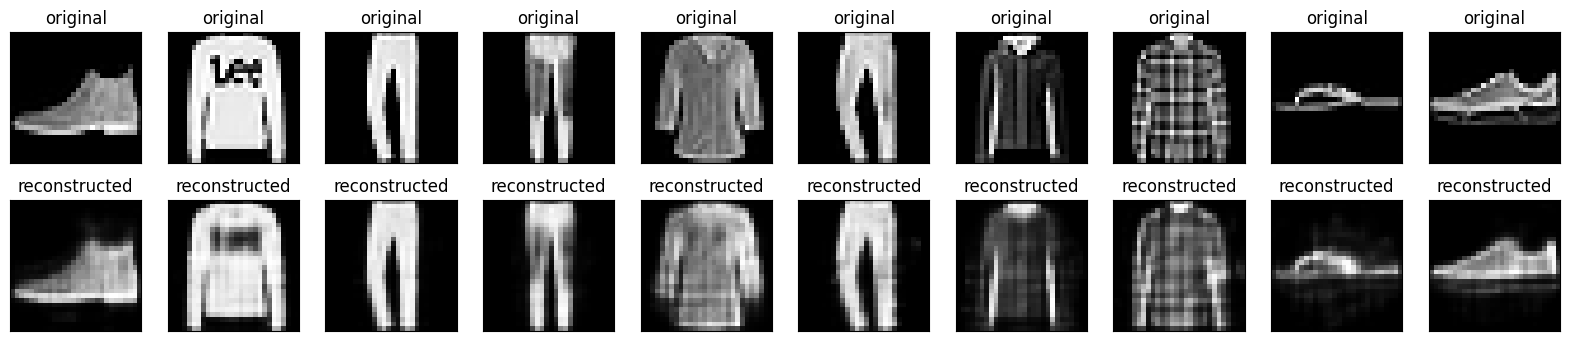

In [ ]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  #display original
  ax = plt.subplot(2, n, i+1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  #display reconstruction
  ax = plt.subplot(2, n, i+1+n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
# reimport the dataset to omit the modifications made earlier

(x_train, _), (x_test, _) = fashion_mnist.load_data()
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print(x_train.shape)

(60000, 28, 28, 1)


In [ ]:
# Adding random noise to the images

noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0.,clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0.,clip_value_max=1.)

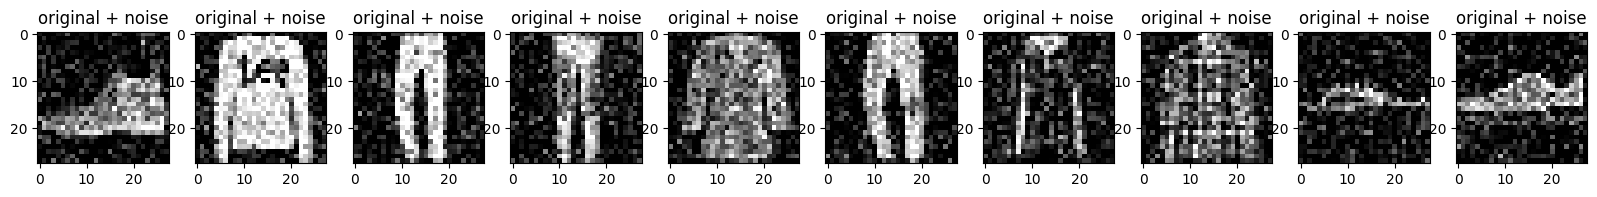

In [ ]:
# Plot the noisy images

n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
  ax = plt.subplot(1, n, i + 1)
  plt.title("original + noise")
  plt.imshow(tf.squeeze(x_test_noisy[i]))
  plt.gray()
plt.show()

In [ ]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
        layers.Input(shape=(28, 28, 1)),
        layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
        layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])
    self.decoder = tf.keras.Sequential([
        layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
        layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
        layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()

In [ ]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [ ]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 62s 32ms/step - loss: 0.0354 - val_loss: 0.0098
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 81s 31ms/step - loss: 0.0094 - val_loss: 0.0087
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 55s 29ms/step - loss: 0.0085 - val_loss: 0.0081
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 91s 34ms/step - loss: 0.0080 - val_loss: 0.0078
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 92s 39ms/step - loss: 0.0077 - val_loss: 0.0076
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 64s 34ms/step - loss: 0.0076 - val_loss: 0.0075
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 87s 37ms/step - loss: 0.0075 - val_loss: 0.0075
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 79s 35ms/step - loss: 0.0074 - val_loss: 0.0074
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 77s 32ms/step - loss: 0.0073 - val_loss: 0.0073
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 90s 37ms/step - loss: 0.0073 - val_loss: 0.0073


In [ ]:
autoencoder.encoder.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 14, 14, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 7, 7, 8)             │           1,160 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,320 (5.16 KB)

 Trainable params: 1,320 (5.16 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
autoencoder.decoder.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_transpose (Conv2DTranspose)   │ (32, 14, 14, 8)             │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (32, 28, 28, 16)            │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 28, 28, 1)             │             145 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,897 (7.41 KB)

 Trainable params: 1,897 (7.41 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Plotting both the noisy images and the denoised images produced by the autoencoder.
encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

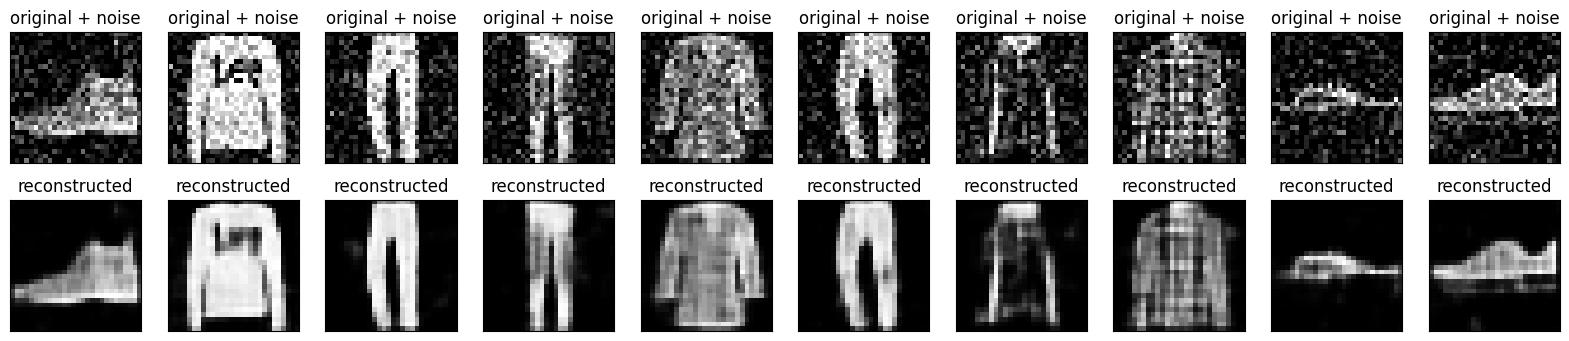

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original + noise
  ax = plt.subplot(2, n, i + 1)
  plt.title("original + noise")
  plt.imshow(tf.squeeze(x_test_noisy[i]))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  bx = plt.subplot(2, n, i + n + 1)
  plt.title("reconstructed")
  plt.imshow(tf.squeeze(decoded_imgs[i]))
  plt.gray()
  bx.get_xaxis().set_visible(False)
  bx.get_yaxis().set_visible(False)
plt.show()